In [27]:
import sys

sys.path.append("./../../src")


from Dataset_mfcc import SpeechCommandsDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchaudio.transforms as T


from helper import evaluate, get_all_preds, plot_loss_and_accuracy
from Transformer import plot_confusion_matrix


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
spec_augment = torch.nn.Sequential(
    T.FrequencyMasking(freq_mask_param=15), T.TimeMasking(time_mask_param=35)
)

valid_dataset = SpeechCommandsDataset("./../../data/validation", mode="modified")
test_dataset = SpeechCommandsDataset("./../../data/test", mode="modified")
train_dataset = SpeechCommandsDataset(
    "./../../data/train",
    mode="modified",
    transform=spec_augment,
)

In [7]:
class SpeechCommandCRNN(nn.Module):
    def __init__(self, num_classes=35, hidden_size=256):
        super(SpeechCommandCRNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.gru_input_size = 128 * (40 // 1)  # 40 is number of MFCC bins

        self.gru = nn.GRU(
            input_size=self.gru_input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.conv(x)  # (batch, channels, freq, time)
        b, c, f, t = x.shape
        x = x.permute(0, 3, 1, 2)  # (batch, time, channels, freq)
        x = x.reshape(b, t, c * f)  # (batch, time, features)

        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [4]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)

model = SpeechCommandCRNN(num_classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    scheduler.step()

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 71.97% | Test Acc: 86.77%
Epoch 2 | Train Acc: 82.70% | Test Acc: 92.43%
Epoch 3 | Train Acc: 85.54% | Test Acc: 93.73%
Epoch 4 | Train Acc: 86.77% | Test Acc: 94.57%
Epoch 5 | Train Acc: 87.91% | Test Acc: 95.18%
Epoch 6 | Train Acc: 88.62% | Test Acc: 95.28%
Epoch 7 | Train Acc: 89.30% | Test Acc: 95.76%
Epoch 8 | Train Acc: 89.74% | Test Acc: 95.52%
Epoch 9 | Train Acc: 90.68% | Test Acc: 95.86%
Epoch 10 | Train Acc: 91.06% | Test Acc: 96.70%
Epoch 11 | Train Acc: 91.31% | Test Acc: 96.77%
Epoch 12 | Train Acc: 91.81% | Test Acc: 96.83%
Epoch 13 | Train Acc: 92.48% | Test Acc: 97.06%
Epoch 14 | Train Acc: 92.75% | Test Acc: 97.17%
Epoch 15 | Train Acc: 92.97% | Test Acc: 97.44%
Epoch 16 | Train Acc: 93.50% | Test Acc: 97.30%
Epoch 17 | Train Acc: 93.71% | Test Acc: 97.52%
Epoch 18 | Train Acc: 93.93% | Test Acc: 97.48%
Epoch 19 | Train Acc: 94.12% | Test Acc: 97.55%
Epoch 20 | Train Acc: 94.12% | Test Acc: 97.48%


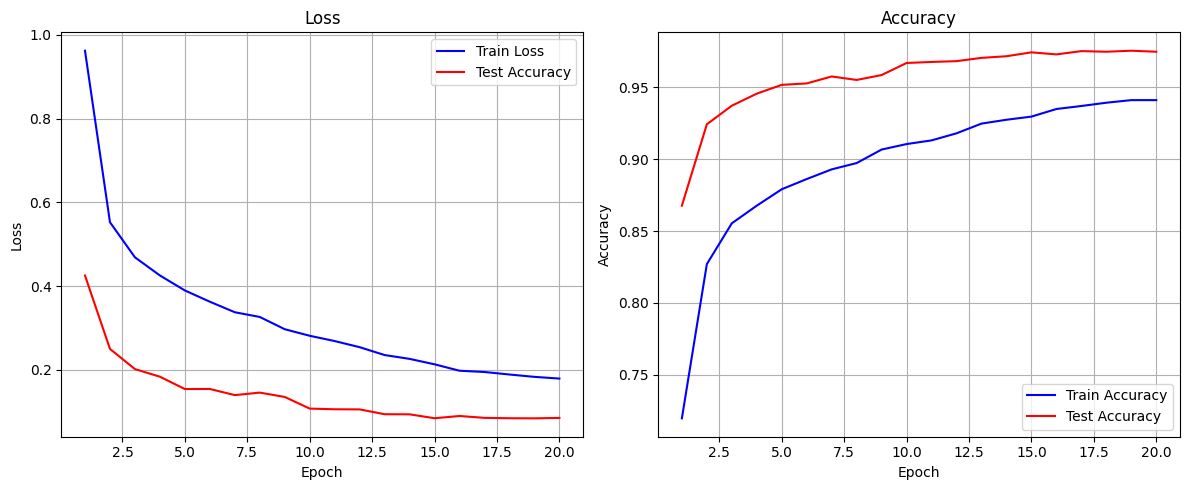

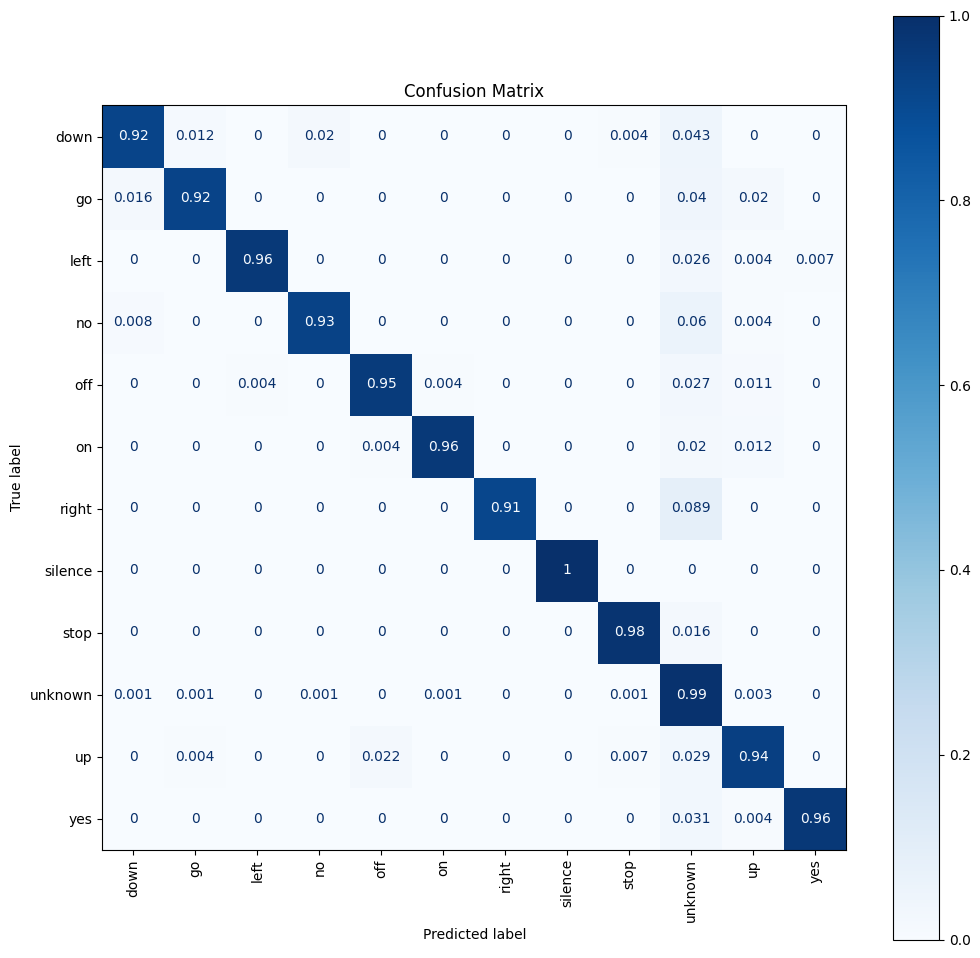

<module 'matplotlib.pyplot' from '/home/aaa/Desktop/deep_learning/ConvolutionalNeuralNeutworks/Transformers/transformer_venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [5]:
plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
)

true_labels, pred_labels = get_all_preds(model, test_loader, device)

plot_confusion_matrix(true_labels, pred_labels, train_dataset, normalize=True)

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)

model = SpeechCommandCRNN(num_classes=12, hidden_size=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    scheduler.step()

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 70.66% | Test Acc: 86.00%
Epoch 2 | Train Acc: 81.69% | Test Acc: 90.75%
Epoch 3 | Train Acc: 85.06% | Test Acc: 91.81%
Epoch 4 | Train Acc: 86.36% | Test Acc: 93.97%
Epoch 5 | Train Acc: 87.61% | Test Acc: 94.82%
Epoch 6 | Train Acc: 88.19% | Test Acc: 95.14%
Epoch 7 | Train Acc: 89.07% | Test Acc: 96.10%
Epoch 8 | Train Acc: 89.88% | Test Acc: 95.96%
Epoch 9 | Train Acc: 90.40% | Test Acc: 96.10%
Epoch 10 | Train Acc: 91.23% | Test Acc: 96.23%
Epoch 11 | Train Acc: 91.48% | Test Acc: 96.77%
Epoch 12 | Train Acc: 91.91% | Test Acc: 97.18%
Epoch 13 | Train Acc: 92.41% | Test Acc: 97.04%
Epoch 14 | Train Acc: 92.73% | Test Acc: 97.01%
Epoch 15 | Train Acc: 93.22% | Test Acc: 97.18%
Epoch 16 | Train Acc: 93.37% | Test Acc: 97.31%
Epoch 17 | Train Acc: 93.65% | Test Acc: 97.48%
Epoch 18 | Train Acc: 93.68% | Test Acc: 97.55%
Epoch 19 | Train Acc: 93.91% | Test Acc: 97.51%
Epoch 20 | Train Acc: 94.03% | Test Acc: 97.57%


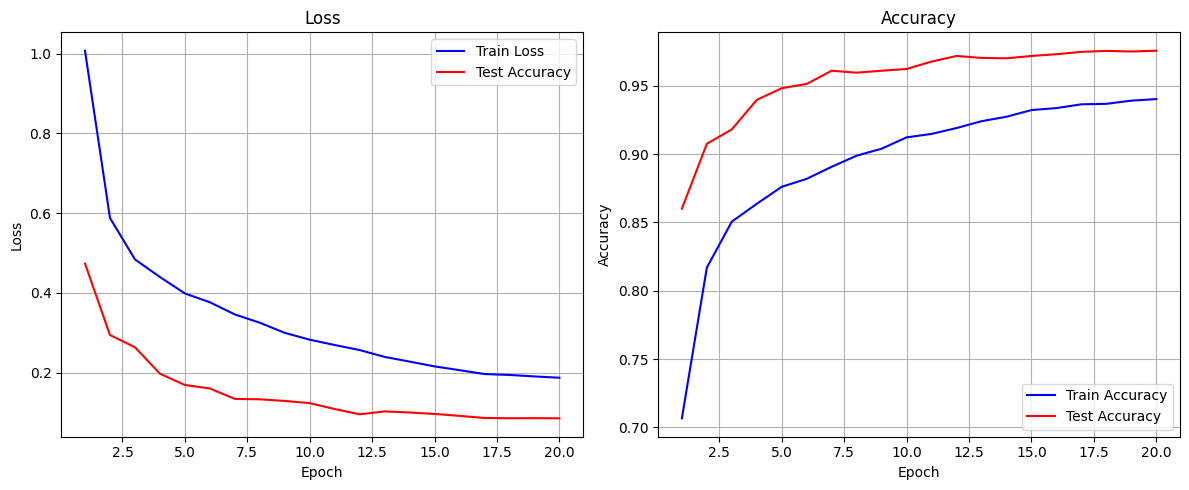

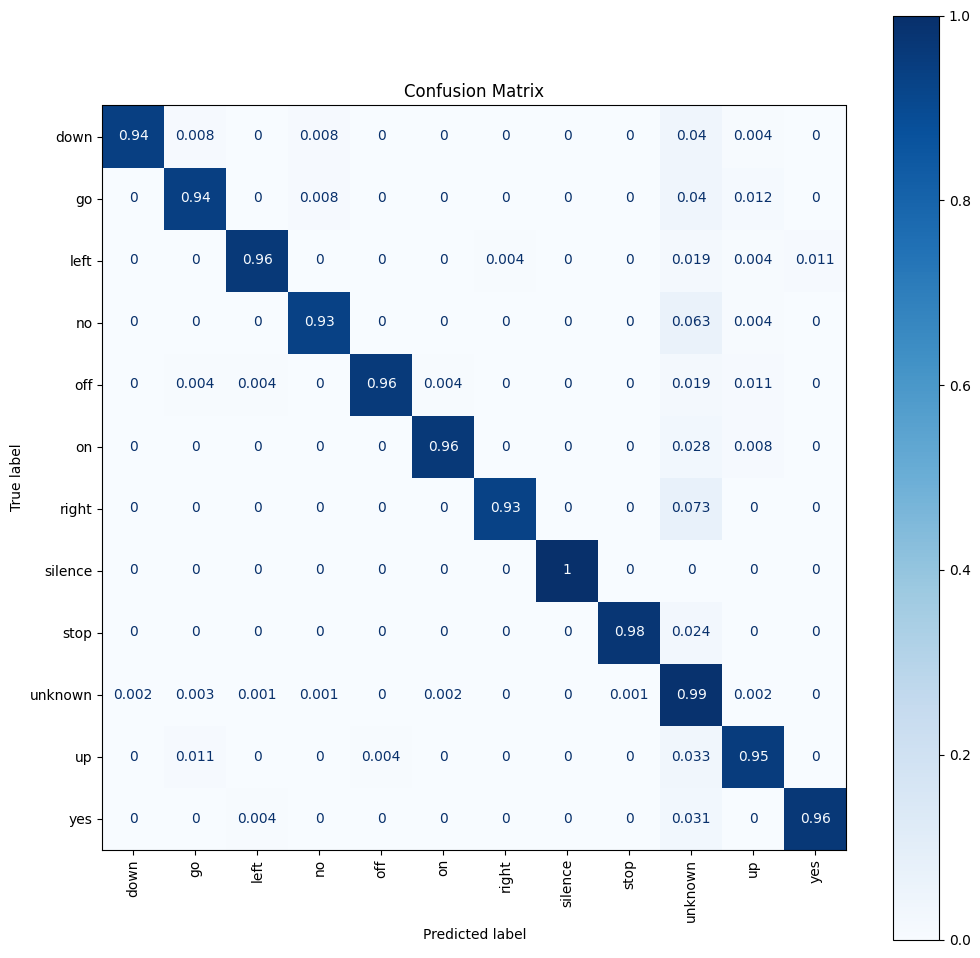

<module 'matplotlib.pyplot' from '/home/aaa/Desktop/deep_learning/ConvolutionalNeuralNeutworks/Transformers/transformer_venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [9]:
plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
)

true_labels, pred_labels = get_all_preds(model, test_loader, device)

plot_confusion_matrix(true_labels, pred_labels, train_dataset, normalize=True)

In [15]:
import torch
import torch.nn as nn


class Attention(nn.Module):
    """Simple Attention module for GRU output"""

    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Linear(dim, 1)

    def forward(self, x):
        # x: (batch, time_steps, hidden_dim)
        attn_weights = torch.softmax(self.attn(x), dim=1)  # (batch, time_steps, 1)
        out = (x * attn_weights).sum(dim=1)  # Weighted sum over time
        return out


class SpeechCommandCRNN_v2(nn.Module):
    def __init__(self, num_classes=35, hidden_size=256):
        super(SpeechCommandCRNN_v2, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
        )

        # After 2 MaxPool layers, frequency dimension (40) becomes 10
        self.gru_input_size = 128 * 10  # (channels × frequency bins)

        self.gru = nn.GRU(
            input_size=self.gru_input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )

        self.attention = Attention(hidden_size * 2)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.conv(x)  # (batch, channels, freq, time)
        b, c, f, t = x.shape
        x = x.permute(0, 3, 1, 2)  # (batch, time, channels, freq)
        x = x.reshape(b, t, c * f)  # (batch, time, features)

        out, _ = self.gru(x)
        out = self.attention(out)
        out = self.classifier(out)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [16]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)

model = SpeechCommandCRNN_v2(num_classes=12, hidden_size=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    scheduler.step()

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 77.47% | Test Acc: 90.94%
Epoch 2 | Train Acc: 86.19% | Test Acc: 94.15%
Epoch 3 | Train Acc: 88.59% | Test Acc: 95.19%
Epoch 4 | Train Acc: 89.72% | Test Acc: 96.10%
Epoch 5 | Train Acc: 90.59% | Test Acc: 96.33%
Epoch 6 | Train Acc: 91.32% | Test Acc: 97.00%
Epoch 7 | Train Acc: 91.71% | Test Acc: 97.24%
Epoch 8 | Train Acc: 92.26% | Test Acc: 96.84%
Epoch 9 | Train Acc: 92.52% | Test Acc: 97.54%
Epoch 10 | Train Acc: 93.15% | Test Acc: 97.48%
Epoch 11 | Train Acc: 93.43% | Test Acc: 97.47%
Epoch 12 | Train Acc: 93.87% | Test Acc: 97.88%
Epoch 13 | Train Acc: 94.10% | Test Acc: 97.97%
Epoch 14 | Train Acc: 94.34% | Test Acc: 97.85%
Epoch 15 | Train Acc: 94.70% | Test Acc: 97.97%
Epoch 16 | Train Acc: 94.98% | Test Acc: 98.11%
Epoch 17 | Train Acc: 95.10% | Test Acc: 97.95%
Epoch 18 | Train Acc: 95.21% | Test Acc: 98.18%
Epoch 19 | Train Acc: 95.29% | Test Acc: 98.21%
Epoch 20 | Train Acc: 95.35% | Test Acc: 98.21%


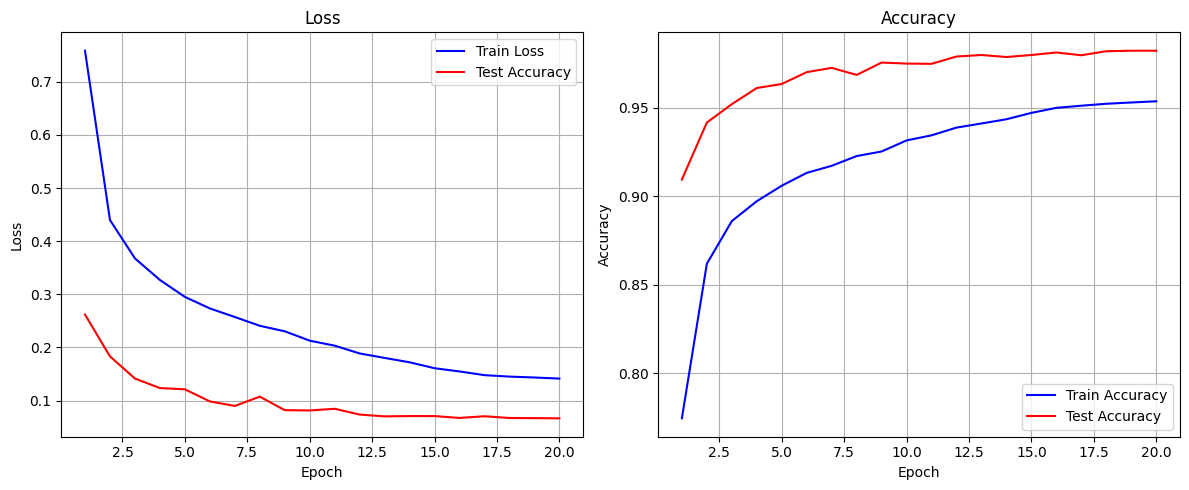

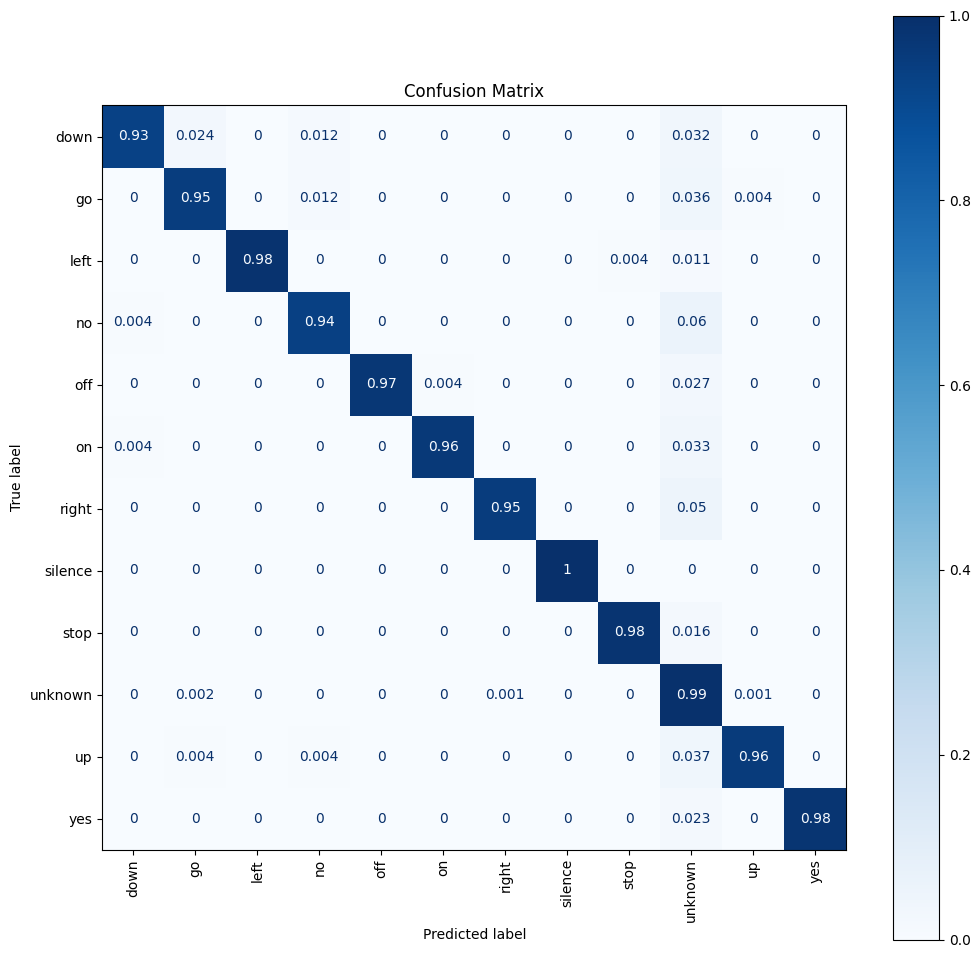

<module 'matplotlib.pyplot' from '/home/aaa/Desktop/deep_learning/ConvolutionalNeuralNeutworks/Transformers/transformer_venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [17]:
plot_loss_and_accuracy(
    train_losses, test_losses, train_accuracies, test_accuracies, num_epochs
)

true_labels, pred_labels = get_all_preds(model, test_loader, device)

plot_confusion_matrix(true_labels, pred_labels, train_dataset, normalize=True)

In [20]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)

model = SpeechCommandCRNN_v2(num_classes=12, hidden_size=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 20

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    scheduler.step()

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 76.51% | Test Acc: 92.32%
Epoch 2 | Train Acc: 86.06% | Test Acc: 94.91%
Epoch 3 | Train Acc: 88.67% | Test Acc: 94.89%
Epoch 4 | Train Acc: 89.74% | Test Acc: 96.29%
Epoch 5 | Train Acc: 90.58% | Test Acc: 96.93%
Epoch 6 | Train Acc: 91.13% | Test Acc: 96.87%
Epoch 7 | Train Acc: 91.84% | Test Acc: 97.13%
Epoch 8 | Train Acc: 92.21% | Test Acc: 97.17%
Epoch 9 | Train Acc: 92.51% | Test Acc: 97.33%
Epoch 10 | Train Acc: 92.95% | Test Acc: 97.70%
Epoch 11 | Train Acc: 93.39% | Test Acc: 97.65%
Epoch 12 | Train Acc: 93.93% | Test Acc: 97.62%
Epoch 13 | Train Acc: 93.94% | Test Acc: 97.68%
Epoch 14 | Train Acc: 94.46% | Test Acc: 97.91%
Epoch 15 | Train Acc: 94.61% | Test Acc: 97.92%
Epoch 16 | Train Acc: 94.83% | Test Acc: 97.95%
Epoch 17 | Train Acc: 94.91% | Test Acc: 97.98%
Epoch 18 | Train Acc: 95.16% | Test Acc: 98.05%
Epoch 19 | Train Acc: 94.98% | Test Acc: 98.11%
Epoch 20 | Train Acc: 95.14% | Test Acc: 98.08%


In [22]:
valid_dataset = SpeechCommandsDataset("./../../data/validation", mode="modified")
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_accuracy = evaluate(model, valid_loader, device)

Test Accuracy: 97.34%, Avg Loss: 0.0992


In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=12,
    pin_memory=True,
    persistent_workers=True,
)

model = SpeechCommandCRNN_v2(num_classes=12, hidden_size=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 10

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for waveforms, labels in train_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)

        outputs = model(waveforms)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    test_acc, test_loss = evaluate(model, test_loader, device, silent=True)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

    scheduler.step()

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%}")

Epoch 1 | Train Acc: 78.10% | Test Acc: 92.23%
Epoch 2 | Train Acc: 86.75% | Test Acc: 94.15%
Epoch 3 | Train Acc: 88.79% | Test Acc: 93.80%
Epoch 4 | Train Acc: 90.04% | Test Acc: 96.50%
Epoch 5 | Train Acc: 90.72% | Test Acc: 96.53%
Epoch 6 | Train Acc: 91.38% | Test Acc: 97.07%
Epoch 7 | Train Acc: 91.94% | Test Acc: 96.93%
Epoch 8 | Train Acc: 92.26% | Test Acc: 96.87%
Epoch 9 | Train Acc: 92.76% | Test Acc: 97.31%
Epoch 10 | Train Acc: 93.04% | Test Acc: 97.44%


20 epochs is better

In [32]:
model = SpeechCommandCRNN_v2(num_classes=12, hidden_size=128).to(device)
summary(model, input_size=(2, 1, 40, 101))

Layer (type:depth-idx)                   Output Shape              Param #
SpeechCommandCRNN_v2                     [2, 12]                   --
├─Sequential: 1-1                        [2, 128, 10, 25]          --
│    └─Conv2d: 2-1                       [2, 32, 40, 101]          320
│    └─BatchNorm2d: 2-2                  [2, 32, 40, 101]          64
│    └─SiLU: 2-3                         [2, 32, 40, 101]          --
│    └─MaxPool2d: 2-4                    [2, 32, 20, 50]           --
│    └─Conv2d: 2-5                       [2, 64, 20, 50]           18,496
│    └─BatchNorm2d: 2-6                  [2, 64, 20, 50]           128
│    └─SiLU: 2-7                         [2, 64, 20, 50]           --
│    └─MaxPool2d: 2-8                    [2, 64, 10, 25]           --
│    └─Conv2d: 2-9                       [2, 128, 10, 25]          73,856
│    └─BatchNorm2d: 2-10                 [2, 128, 10, 25]          256
│    └─SiLU: 2-11                        [2, 128, 10, 25]          --
├─GR

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
validation_losses = []
validation_accuracies = []

for num_of_tries in range(10):
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=12,
        pin_memory=True,
        persistent_workers=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=12,
        pin_memory=True,
        persistent_workers=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=12,
        pin_memory=True,
        persistent_workers=True,
    )

    model = SpeechCommandCRNN_v2(num_classes=12, hidden_size=128).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

    num_epochs = 20

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for waveforms, labels in train_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)

            outputs = model(waveforms)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()

    train_accuracy, train_loss = evaluate(model, train_loader, device)